In [2]:
# Quick CUDA check
import torch

print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Device count: {torch.cuda.device_count()}")
    print(f"Current device: {torch.cuda.current_device()}")
    print(f"Device name: {torch.cuda.get_device_name()}")

CUDA available: True
Device count: 1
Current device: 0
Device name: NVIDIA GeForce RTX 3060


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\saifh\.cache\kagglehub\datasets\meowmeowmeowmeowmeow\gtsrb-german-traffic-sign\versions\1


In [4]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from matplotlib.image import imread
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from pathlib import Path

np.random.seed(42)


In [5]:
print(path)


C:\Users\saifh\.cache\kagglehub\datasets\meowmeowmeowmeowmeow\gtsrb-german-traffic-sign\versions\1


In [6]:
data_dir = Path(path)
test_path = Path(path) / "Test"
train_path = Path(path) / "Train"

In [7]:
no_categories = len(os.listdir(train_path))
print(no_categories)

43


In [8]:
# okay, so we have 43 categories, let's assign labels to each category
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }


In [9]:
train_folders = os.listdir(train_path)

train_number = []
class_num = []


for folder in train_folders:
    train_files = Path(train_path) / folder
    train_number.append(len(list(train_files.iterdir())))
    class_num.append(classes[int(folder)])


zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]


    


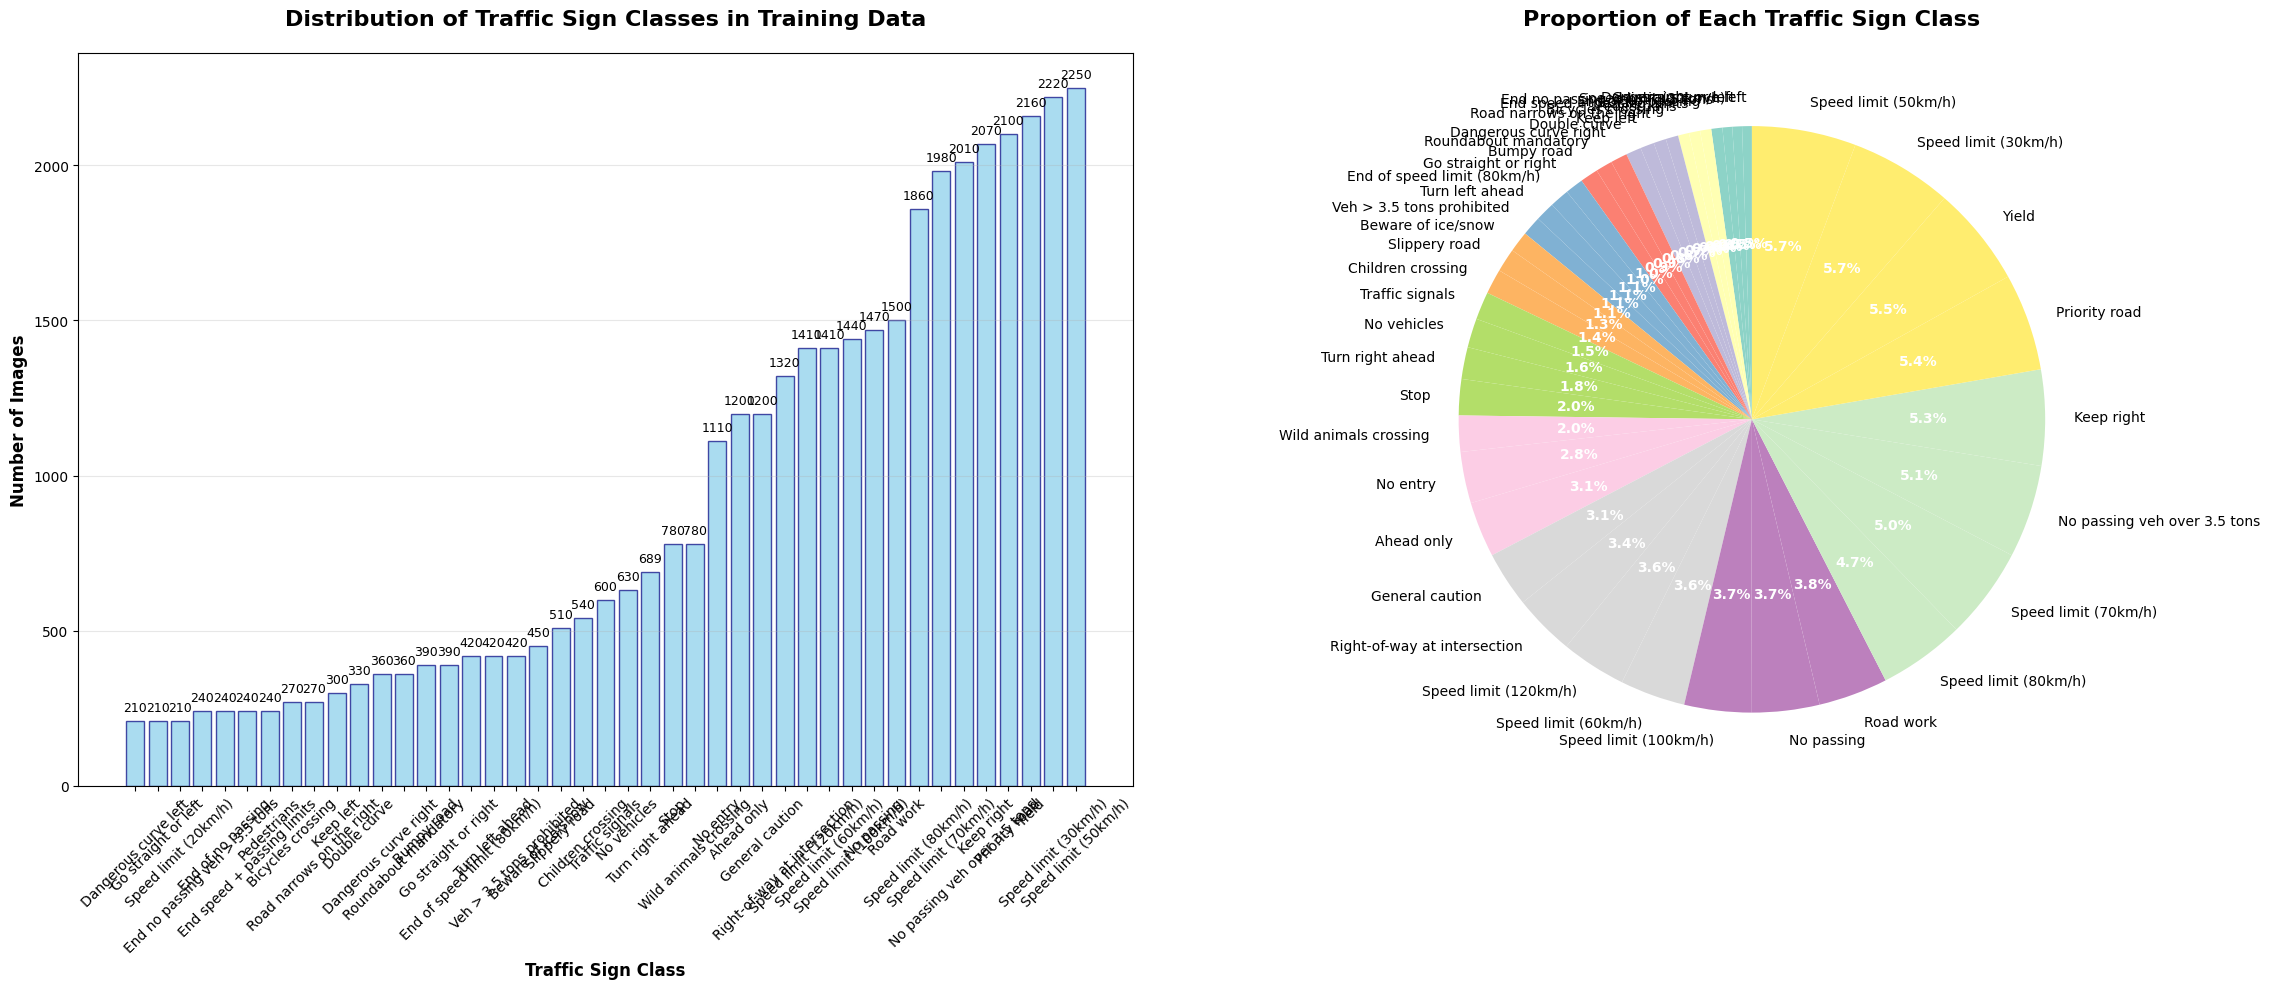

=== DATA DISTRIBUTION OBSERVATIONS ===
Total training images: 39209
Number of classes: 43
Average images per class: 911.8
Class with most images: Speed limit (50km/h) (2250 images)
Class with least images: Dangerous curve left (210 images)
Standard deviation: 687.7
Class imbalance ratio (max/min): 10.7:1
⚠️  Significant class imbalance detected - consider data augmentation for minority classes


In [10]:
# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

# Bar chart
bars = ax1.bar(class_num, train_number, color='skyblue', edgecolor='navy', alpha=0.7)
ax1.set_title('Distribution of Traffic Sign Classes in Training Data', fontsize=16, fontweight='bold', pad=20)
ax1.set_xlabel('Traffic Sign Class', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Images', fontsize=12, fontweight='bold')
ax1.tick_params(axis='x', rotation=45, labelsize=10)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + max(train_number)*0.01,
             f'{int(height)}', ha='center', va='bottom', fontsize=9)

# Pie chart
colors = plt.cm.Set3(np.linspace(0, 1, len(class_num)))
wedges, texts, autotexts = ax2.pie(train_number, labels=class_num, autopct='%1.1f%%', 
                                   colors=colors, startangle=90)
ax2.set_title('Proportion of Each Traffic Sign Class', fontsize=16, fontweight='bold', pad=20)

# Style the pie chart text
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(10)

plt.tight_layout()
plt.show()

# Print observations
print("=== DATA DISTRIBUTION OBSERVATIONS ===")
print(f"Total training images: {sum(train_number)}")
print(f"Number of classes: {len(class_num)}")
print(f"Average images per class: {sum(train_number)/len(class_num):.1f}")
print(f"Class with most images: {class_num[train_number.index(max(train_number))]} ({max(train_number)} images)")
print(f"Class with least images: {class_num[train_number.index(min(train_number))]} ({min(train_number)} images)")
print(f"Standard deviation: {np.std(train_number):.1f}")

# Check for class imbalance
imbalance_ratio = max(train_number) / min(train_number)
print(f"Class imbalance ratio (max/min): {imbalance_ratio:.1f}:1")

if imbalance_ratio > 5:
    print("⚠️  Significant class imbalance detected - consider data augmentation for minority classes")
elif imbalance_ratio > 2:
    print("⚠️  Moderate class imbalance - monitor training performance")
else:
    print("✅  Relatively balanced dataset")

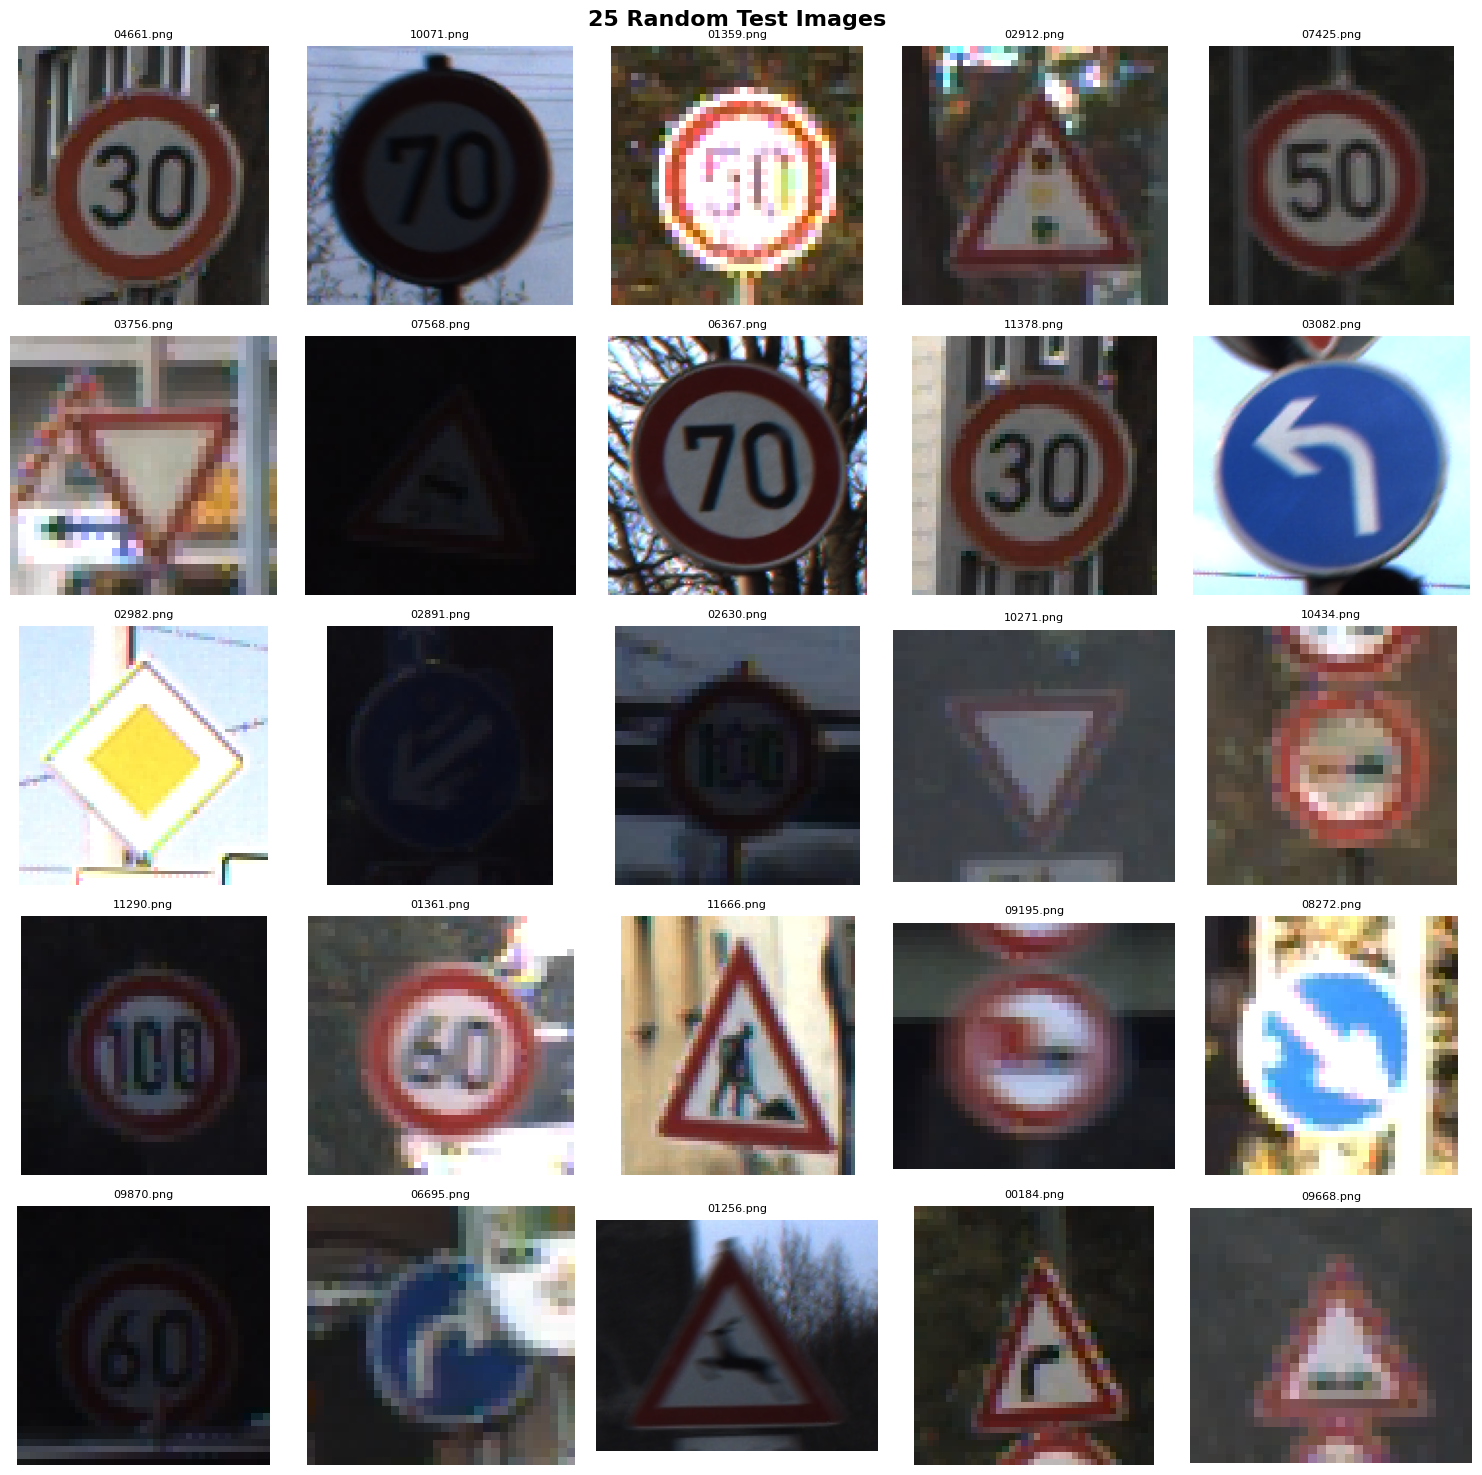

Displayed 25 random images from 12630 total images


In [11]:
import random
# Get all image files from the test directory
image_files = []
for file in os.listdir(test_path):
    if file.lower().endswith(('.png', '.jpg', '.jpeg', '.ppm')):
        image_files.append(file)

if len(image_files) >= 25:
    # Select 25 random images
    random_images = random.sample(image_files, 25)
    
    # Create 5x5 subplot grid
    fig, axes = plt.subplots(5, 5, figsize=(15, 15))
    fig.suptitle('25 Random Test Images', fontsize=16, fontweight='bold')
    
    # Flatten axes for easier iteration
    axes = axes.flatten()
    
    for idx, image_name in enumerate(random_images):
        image_path = test_path / image_name
        
        # Read and display image
        img = cv2.imread(str(image_path))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            
            axes[idx].imshow(img)
            axes[idx].set_title(image_name, fontsize=8)
            axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Displayed 25 random images from {len(image_files)} total images")
    
elif len(image_files) > 0:
    print(f"Only {len(image_files)} images found, need at least 25")
else:
    print("No image files found in test directory")

# All set, now it is time to actually set up the training data and train a model on it

In [14]:
IMG_HEIGHT = 32
IMG_WIDTH = 32

image_data = []
image_labels = []

print(f"Starting to load images from {data_dir / 'Train'}...")

for i in range(no_categories):
    category_path = data_dir / 'Train' / str(i)
    images = os.listdir(category_path)
    print(f"\nProcessing category {i} ({len(images)} images) from {category_path}...")

    loaded_count = 0
    skipped_count = 0

    for idx, img in enumerate(images, 1):
        try:
            img_path = category_path / img
            image = cv2.imread(str(img_path))

            if image is not None:
                image_fromarray = Image.fromarray(image, 'RGB')
                resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
                image_data.append(np.array(resize_image))
                image_labels.append(i)
                loaded_count += 1
            else:
                print(f"[Warning] Could not load image: {img}")
                skipped_count += 1

        except Exception as e:
            print(f"[Error] Processing {img}: {str(e)}")
            skipped_count += 1

        # Print status every 50 images
        if idx % 50 == 0:
            print(f"  Processed {idx}/{len(images)} images...")

    print(f"Finished category {i}: {loaded_count} loaded, {skipped_count} skipped.")

image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(f"\nAll categories processed.")
print(f"Total images loaded: {len(image_data)}")
print(f"Image data shape: {image_data.shape}")
print(f"Image labels shape: {image_labels.shape}")

Starting to load images from C:\Users\saifh\.cache\kagglehub\datasets\meowmeowmeowmeowmeow\gtsrb-german-traffic-sign\versions\1\Train...

Processing category 0 (210 images) from C:\Users\saifh\.cache\kagglehub\datasets\meowmeowmeowmeowmeow\gtsrb-german-traffic-sign\versions\1\Train\0...
  Processed 50/210 images...
  Processed 100/210 images...
  Processed 150/210 images...
  Processed 200/210 images...
Finished category 0: 210 loaded, 0 skipped.

Processing category 1 (2220 images) from C:\Users\saifh\.cache\kagglehub\datasets\meowmeowmeowmeowmeow\gtsrb-german-traffic-sign\versions\1\Train\1...
  Processed 50/2220 images...
  Processed 100/2220 images...
  Processed 150/2220 images...
  Processed 200/2220 images...
  Processed 250/2220 images...
  Processed 300/2220 images...
  Processed 350/2220 images...
  Processed 400/2220 images...
  Processed 450/2220 images...
  Processed 500/2220 images...
  Processed 550/2220 images...
  Processed 600/2220 images...
  Processed 650/2220 image

In [16]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

In [17]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255   #normailize to prevent exploding gradient
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 32, 32, 3)
X_valid.shape (11763, 32, 32, 3)
y_train.shape (27446,)
y_valid.shape (11763,)
